In [1]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, KFold
import xgboost as xgb
from scripts.function_utils import correct_wind_direction, plot_results, performance_metrics, build_model, past_timesteps, add_energy_variation

In [2]:
df = pd.read_csv("../../data/loureiro_weather_45houses_selected.csv")
df.drop(["lag_1","lag_2","lag_3","lag_4","lag_96", "lag_192", "lag_288","lag_384","lag_480","lag_576","lag_672", "DayOfWeek", "Hour"], inplace=True, axis=1)
#df = correct_wind_direction(df).drop(["Temp_Max","Temp_Min","Rumo_Vento_Med", "Rumo_Vento_Max", "Intensidade_Vento_Max"], axis=1)
df.Time = pd.to_datetime(df.Time)
df

,Time,Location,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,Energy
0,2022-05-12 12:00:00,Energy_1,22.30,55.0,348.0,2.40,3.30,26.20,0.0,0.0,547.70,0.039
1,2022-05-12 12:15:00,Energy_1,21.65,62.0,328.5,3.55,4.80,26.25,0.0,0.0,372.85,0.061
2,2022-05-12 12:30:00,Energy_1,20.70,67.0,321.0,4.20,5.00,25.60,0.0,0.0,412.80,0.038
3,2022-05-12 12:45:00,Energy_1,20.20,67.5,325.0,4.15,5.15,25.05,0.0,0.0,282.10,0.069
4,2022-05-12 13:00:00,Energy_1,20.30,72.0,325.0,3.10,4.10,24.50,0.0,0.0,359.00,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...
1680475,2023-06-05 10:45:00,Energy_96,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55,0.010
1680476,2023-06-05 11:00:00,Energy_96,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50,0.009
1680477,2023-06-05 11:15:00,Energy_96,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75,0.010
1680478,2023-06-05 11:30:00,Energy_96,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00,0.039


In [3]:
df.isnull().sum()

Time                   0
Location               0
Avg_Temp               0
Avg_Rel_Humidity       0
Avg_Wind_Direction     0
Avg_Wind_Speed         0
Max_Inst_Wind_Speed    0
Inst_Temp              0
Quantity_Precip        0
Max_Inst_Precip        0
Total_Global_Rad       0
Energy                 0
dtype: int64

## Plot some data

In [4]:
# Drop NaN values from weather dataset
weather_cols = ["Avg_Temp", "Avg_Rel_Humidity", "Avg_Wind_Direction", "Avg_Wind_Speed", "Max_Inst_Wind_Speed", "Inst_Temp","Quantity_Precip", "Max_Inst_Precip", "Total_Global_Rad"]
df_weather = df.loc[:, weather_cols]
df_weather

,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad
0,22.30,55.0,348.0,2.40,3.30,26.20,0.0,0.0,547.70
1,21.65,62.0,328.5,3.55,4.80,26.25,0.0,0.0,372.85
2,20.70,67.0,321.0,4.20,5.00,25.60,0.0,0.0,412.80
3,20.20,67.5,325.0,4.15,5.15,25.05,0.0,0.0,282.10
4,20.30,72.0,325.0,3.10,4.10,24.50,0.0,0.0,359.00
...,...,...,...,...,...,...,...,...,...
1680475,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55
1680476,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50
1680477,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75
1680478,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00


In [5]:
df_noweather = df.iloc[:, ~df.columns.isin(weather_cols)]
df_noweather

,Time,Location,Energy
0,2022-05-12 12:00:00,Energy_1,0.039
1,2022-05-12 12:15:00,Energy_1,0.061
2,2022-05-12 12:30:00,Energy_1,0.038
3,2022-05-12 12:45:00,Energy_1,0.069
4,2022-05-12 13:00:00,Energy_1,0.063
...,...,...,...
1680475,2023-06-05 10:45:00,Energy_96,0.010
1680476,2023-06-05 11:00:00,Energy_96,0.009
1680477,2023-06-05 11:15:00,Energy_96,0.010
1680478,2023-06-05 11:30:00,Energy_96,0.039


### First Model (all weather features + last hour)

In [6]:
n_timesteps = 4
past = past_timesteps(df, n_timesteps)
X1, y1 = past.drop(["Time", "Location", "Energy"], axis=1), past.Energy
X1

100%|██████████| 4/4 [00:00<00:00, 28.61it/s]


,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,lag_1,lag_2,lag_3,lag_4
0,20.30,72.0,325.0,3.10,4.10,24.50,0.0,0.0,359.00,0.069,0.038,0.061,0.039
1,20.10,71.0,357.0,3.35,4.90,24.60,0.0,0.0,231.55,0.063,0.069,0.038,0.061
2,20.00,72.0,348.0,3.40,4.60,24.40,0.0,0.0,205.90,0.082,0.063,0.069,0.038
3,20.40,73.0,343.0,4.15,5.65,24.35,0.0,0.0,435.95,0.075,0.082,0.063,0.069
4,20.60,73.0,342.0,4.30,5.70,25.20,0.0,0.0,497.50,0.092,0.075,0.082,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1680295,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55,0.009,0.028,0.039,0.036
1680296,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50,0.010,0.009,0.028,0.039
1680297,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75,0.009,0.010,0.009,0.028
1680298,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00,0.010,0.009,0.010,0.009


In [7]:
pd.DataFrame(y1)

,Energy
0,0.063
1,0.082
2,0.075
3,0.092
4,0.064
...,...
1680295,0.010
1680296,0.009
1680297,0.010
1680298,0.039


### Second Model (all weather features + last 24 hours)
##### Since the data is in intervals of 15 minutes, it will add 24 * 4 = 96 new features

In [8]:
n_timesteps = 96
past = past_timesteps(df, n_timesteps)
X2, y2 = past.drop(["Time", "Location", "Energy"], axis=1), past.Energy
X2

100%|██████████| 96/96 [00:02<00:00, 37.12it/s]


,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,lag_1,...,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96
0,20.60,75.0,337.0,3.60,4.70,26.70,0.0,0.0,523.60,0.051,...,0.130,0.064,0.092,0.075,0.082,0.063,0.069,0.038,0.061,0.039
1,20.60,74.0,330.5,3.45,4.50,27.10,0.0,0.0,522.85,0.043,...,0.107,0.130,0.064,0.092,0.075,0.082,0.063,0.069,0.038,0.061
2,20.60,75.0,328.0,3.50,4.30,27.30,0.0,0.0,519.20,0.038,...,0.068,0.107,0.130,0.064,0.092,0.075,0.082,0.063,0.069,0.038
3,21.05,75.5,337.5,3.50,4.70,27.55,0.0,0.0,501.90,0.065,...,0.068,0.068,0.107,0.130,0.064,0.092,0.075,0.082,0.063,0.069
4,21.30,76.0,350.0,3.60,4.90,27.80,0.0,0.0,504.50,0.037,...,0.084,0.068,0.068,0.107,0.130,0.064,0.092,0.075,0.082,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676155,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55,0.009,...,0.041,0.012,0.010,0.009,0.009,0.022,0.037,0.041,0.011,0.010
1676156,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50,0.010,...,0.038,0.041,0.012,0.010,0.009,0.009,0.022,0.037,0.041,0.011
1676157,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75,0.009,...,0.023,0.038,0.041,0.012,0.010,0.009,0.009,0.022,0.037,0.041
1676158,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00,0.010,...,0.009,0.023,0.038,0.041,0.012,0.010,0.009,0.009,0.022,0.037


In [9]:
pd.DataFrame(y2)

,Energy
0,0.043
1,0.038
2,0.065
3,0.037
4,0.022
...,...
1676155,0.010
1676156,0.009
1676157,0.010
1676158,0.039


### Third Model (all weather features + last 7 days at exact same time)
##### Multiply i by 96 to skip a day

In [10]:
features_7 = df.sort_values(by=['Location', 'Time'])
for i in range(1, 8):
    features_7.loc[features_7['Time'].shift(i*96) == features_7['Time'] - pd.Timedelta(i, 'day'), f"lag_{i*96}"] = features_7['Energy'].shift(i*96)
features_7.dropna(inplace=True)
features_7.reset_index(drop=True, inplace=True)
features_7

,Time,Location,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,Energy,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,2022-05-19 12:00:00,Energy_1,20.10,65.0,332.0,4.20,6.40,25.70,0.0,0.0,529.00,0.020,0.088,0.034,0.040,0.017,0.071,0.043,0.039
1,2022-05-19 12:15:00,Energy_1,20.45,64.0,337.5,4.35,6.15,26.00,0.0,0.0,529.05,0.096,0.058,0.035,0.064,0.028,0.051,0.038,0.061
2,2022-05-19 12:30:00,Energy_1,20.70,63.0,340.0,4.80,6.70,26.40,0.0,0.0,527.30,0.085,0.081,0.040,0.070,0.067,0.062,0.065,0.038
3,2022-05-19 12:45:00,Energy_1,20.60,65.0,338.0,4.95,7.60,26.65,0.0,0.0,523.05,0.072,0.264,0.029,0.052,0.188,0.073,0.037,0.069
4,2022-05-19 13:00:00,Energy_1,20.60,66.0,336.0,5.60,7.80,26.80,0.0,0.0,493.70,0.071,0.127,0.024,0.063,0.038,0.074,0.022,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650235,2023-06-05 10:45:00,Energy_96,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55,0.010,0.010,0.014,0.039,0.026,0.010,0.039,0.029
1650236,2023-06-05 11:00:00,Energy_96,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50,0.009,0.011,0.041,0.032,0.009,0.009,0.032,0.009
1650237,2023-06-05 11:15:00,Energy_96,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75,0.010,0.041,0.038,0.009,0.009,0.026,0.009,0.009
1650238,2023-06-05 11:30:00,Energy_96,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00,0.039,0.037,0.018,0.010,0.010,0.039,0.010,0.010


In [11]:
X3, y3 = features_7.drop(["Time", "Location", "Energy"], axis=1), features_7.Energy
X3

,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,Total_Global_Rad,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,20.10,65.0,332.0,4.20,6.40,25.70,0.0,0.0,529.00,0.088,0.034,0.040,0.017,0.071,0.043,0.039
1,20.45,64.0,337.5,4.35,6.15,26.00,0.0,0.0,529.05,0.058,0.035,0.064,0.028,0.051,0.038,0.061
2,20.70,63.0,340.0,4.80,6.70,26.40,0.0,0.0,527.30,0.081,0.040,0.070,0.067,0.062,0.065,0.038
3,20.60,65.0,338.0,4.95,7.60,26.65,0.0,0.0,523.05,0.264,0.029,0.052,0.188,0.073,0.037,0.069
4,20.60,66.0,336.0,5.60,7.80,26.80,0.0,0.0,493.70,0.127,0.024,0.063,0.038,0.074,0.022,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650235,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,443.55,0.010,0.014,0.039,0.026,0.010,0.039,0.029
1650236,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,506.50,0.011,0.041,0.032,0.009,0.009,0.032,0.009
1650237,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,516.75,0.041,0.038,0.009,0.009,0.026,0.009,0.009
1650238,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,518.00,0.037,0.018,0.010,0.010,0.039,0.010,0.010


In [12]:
pd.DataFrame(y3)

,Energy
0,0.020
1,0.096
2,0.085
3,0.072
4,0.071
...,...
1650235,0.010
1650236,0.009
1650237,0.010
1650238,0.039


### Fourth Model (last hour + last 7 days at exact same time + DayOfWeek + Hour)

In [13]:
features_7 = df.sort_values(by=['Location', 'Time'])
for i in range(1, 5):
    features_7.loc[features_7['Time'].shift(i) == features_7['Time'] - pd.Timedelta(i*15, 'm'), f"lag_{i}"] = features_7['Energy'].shift(i)
for i in range(1, 8):
    features_7.loc[features_7['Time'].shift(i*96) == features_7['Time'] - pd.Timedelta(i, 'day'), f"lag_{i*96}"] = features_7['Energy'].shift(i*96)
features_7.dropna(inplace=True)
features_7.reset_index(drop=True, inplace=True)
features_7

,Time,Location,Avg_Temp,Avg_Rel_Humidity,Avg_Wind_Direction,Avg_Wind_Speed,Max_Inst_Wind_Speed,Inst_Temp,Quantity_Precip,Max_Inst_Precip,...,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672
0,2022-05-19 12:00:00,Energy_1,20.10,65.0,332.0,4.20,6.40,25.70,0.0,0.0,...,0.020,0.049,0.021,0.088,0.034,0.040,0.017,0.071,0.043,0.039
1,2022-05-19 12:15:00,Energy_1,20.45,64.0,337.5,4.35,6.15,26.00,0.0,0.0,...,0.014,0.020,0.049,0.058,0.035,0.064,0.028,0.051,0.038,0.061
2,2022-05-19 12:30:00,Energy_1,20.70,63.0,340.0,4.80,6.70,26.40,0.0,0.0,...,0.020,0.014,0.020,0.081,0.040,0.070,0.067,0.062,0.065,0.038
3,2022-05-19 12:45:00,Energy_1,20.60,65.0,338.0,4.95,7.60,26.65,0.0,0.0,...,0.096,0.020,0.014,0.264,0.029,0.052,0.188,0.073,0.037,0.069
4,2022-05-19 13:00:00,Energy_1,20.60,66.0,336.0,5.60,7.80,26.80,0.0,0.0,...,0.085,0.096,0.020,0.127,0.024,0.063,0.038,0.074,0.022,0.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650235,2023-06-05 10:45:00,Energy_96,19.80,78.0,319.0,2.20,3.30,23.30,0.0,0.0,...,0.028,0.039,0.036,0.010,0.014,0.039,0.026,0.010,0.039,0.029
1650236,2023-06-05 11:00:00,Energy_96,20.50,76.0,351.0,2.70,4.10,23.90,0.0,0.0,...,0.009,0.028,0.039,0.011,0.041,0.032,0.009,0.009,0.032,0.009
1650237,2023-06-05 11:15:00,Energy_96,21.00,74.0,343.0,2.50,4.15,24.30,0.0,0.0,...,0.010,0.009,0.028,0.041,0.038,0.009,0.009,0.026,0.009,0.009
1650238,2023-06-05 11:30:00,Energy_96,20.80,76.0,334.0,2.80,5.00,24.50,0.0,0.0,...,0.009,0.010,0.009,0.037,0.018,0.010,0.010,0.039,0.010,0.010


In [14]:
X4 = features_7.drop(weather_cols, axis=1)
X4["DayOfWeek"] = past.Time.dt.dayofweek
X4["Hour"] = past.Time.dt.hour
X4.drop(["Time", "Location", "Energy"], axis=1, inplace=True)
y4 = y3
X4

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,DayOfWeek,Hour
0,0.014,0.020,0.049,0.021,0.088,0.034,0.040,0.017,0.071,0.043,0.039,4,12
1,0.020,0.014,0.020,0.049,0.058,0.035,0.064,0.028,0.051,0.038,0.061,4,12
2,0.096,0.020,0.014,0.020,0.081,0.040,0.070,0.067,0.062,0.065,0.038,4,12
3,0.085,0.096,0.020,0.014,0.264,0.029,0.052,0.188,0.073,0.037,0.069,4,12
4,0.072,0.085,0.096,0.020,0.127,0.024,0.063,0.038,0.074,0.022,0.063,4,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650235,0.009,0.028,0.039,0.036,0.010,0.014,0.039,0.026,0.010,0.039,0.029,3,10
1650236,0.010,0.009,0.028,0.039,0.011,0.041,0.032,0.009,0.009,0.032,0.009,3,11
1650237,0.009,0.010,0.009,0.028,0.041,0.038,0.009,0.009,0.026,0.009,0.009,3,11
1650238,0.010,0.009,0.010,0.009,0.037,0.018,0.010,0.010,0.039,0.010,0.010,3,11


In [15]:
y4

0          0.020
1          0.096
2          0.085
3          0.072
4          0.071
           ...  
1650235    0.010
1650236    0.009
1650237    0.010
1650238    0.039
1650239    0.039
Name: Energy, Length: 1650240, dtype: float64

### Fifth Model (last hour + DayOfWeek + Hour + Variation)

In [16]:
n_timesteps = 4
past_5th = past_timesteps(df, n_timesteps)
past_5th.drop(weather_cols, axis=1, inplace=True)
vari = add_energy_variation(past_5th)
X5 = past_5th.copy()
X5.drop(["Time", "Location", "Energy"], axis=1, inplace=True)
X5["DayOfWeek"] = past_5th.Time.dt.dayofweek
X5["Hour"] = past_5th.Time.dt.hour
y5 = past_5th.Energy
X5

100%|██████████| 4/4 [00:00<00:00, 29.14it/s]


,lag_1,lag_2,lag_3,lag_4,Variation,DayOfWeek,Hour
0,0.069,0.038,0.061,0.039,0.000000,3,13
1,0.063,0.069,0.038,0.061,0.000000,3,13
2,0.082,0.063,0.069,0.038,0.301381,3,13
3,0.075,0.082,0.063,0.069,-0.085477,3,13
4,0.092,0.075,0.082,0.063,0.226503,3,14
...,...,...,...,...,...,...,...
1680295,0.009,0.028,0.039,0.036,-0.678686,0,10
1680296,0.010,0.009,0.028,0.039,0.109878,0,11
1680297,0.009,0.010,0.009,0.028,-0.100899,0,11
1680298,0.010,0.009,0.010,0.009,0.109878,0,11


In [17]:
pd.DataFrame(y5)

,Energy
0,0.063
1,0.082
2,0.075
3,0.092
4,0.064
...,...
1680295,0.010
1680296,0.009
1680297,0.010
1680298,0.039


### Sixth Model (last hour + last 7 days + DayOfWeek + Hour + Variation)

In [18]:
X6 = features_7.copy()
tmp = add_energy_variation(pd.DataFrame(X6))
X6["Variation"] = tmp["Variation"]
X6.drop(weather_cols, axis=1, inplace=True)
X6["DayOfWeek"] = features_7.Time.dt.dayofweek
X6["Hour"] = features_7.Time.dt.hour
X6.drop(["Time", "Location", "Energy"], axis=1, inplace=True)
y6 = y4.copy()
X6

,lag_1,lag_2,lag_3,lag_4,lag_96,lag_192,lag_288,lag_384,lag_480,lag_576,lag_672,Variation,DayOfWeek,Hour
0,0.014,0.020,0.049,0.021,0.088,0.034,0.040,0.017,0.071,0.043,0.039,0.000000,3,12
1,0.020,0.014,0.020,0.049,0.058,0.035,0.064,0.028,0.051,0.038,0.061,0.000000,3,12
2,0.096,0.020,0.014,0.020,0.081,0.040,0.070,0.067,0.062,0.065,0.038,3.797601,3,12
3,0.085,0.096,0.020,0.014,0.264,0.029,0.052,0.188,0.073,0.037,0.069,-0.114676,3,12
4,0.072,0.085,0.096,0.020,0.127,0.024,0.063,0.038,0.074,0.022,0.063,-0.153041,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1650235,0.009,0.028,0.039,0.036,0.010,0.014,0.039,0.026,0.010,0.039,0.029,-0.678686,0,10
1650236,0.010,0.009,0.028,0.039,0.011,0.041,0.032,0.009,0.009,0.032,0.009,0.109878,0,11
1650237,0.009,0.010,0.009,0.028,0.041,0.038,0.009,0.009,0.026,0.009,0.009,-0.100899,0,11
1650238,0.010,0.009,0.010,0.009,0.037,0.018,0.010,0.010,0.039,0.010,0.010,0.109878,0,11


In [19]:
y6

0          0.020
1          0.096
2          0.085
3          0.072
4          0.071
           ...  
1650235    0.010
1650236    0.009
1650237    0.010
1650238    0.039
1650239    0.039
Name: Energy, Length: 1650240, dtype: float64

## Train and Predict Models

In [20]:
# First Model (all weather features)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
model1, preds1 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X1_train, y1_train, X1_test)

# Second Model (weather features + last 24 hours)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)
model2, preds2 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X2_train, y2_train, X2_test)

# Third Model (weather features + last 7 days at the exact same time)
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.2, random_state=42)
model3, preds3 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X3_train, y3_train, X3_test)

# Fourth Model (last hour + last 7 days at exact same time + DayOfWeek + Hour))
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.2, random_state=42)
model4, preds4 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X4_train, y4_train, X4_test)

# Fifth Model (last hour + DayOfWeek + Hour + Variation)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5, test_size=0.2, random_state=42)
model5, preds5 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X5_train, y5_train, X5_test)

# Sixth Model (last hour + last 7 days + DayOfWeek + Hour + Variation)
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6, test_size=0.2, random_state=42)
model6, preds6 = build_model(xgb.XGBRegressor(seed=0, tree_method='gpu_hist'), X6_train, y6_train, X6_test)

## Plot Models and Show Performance Metrics

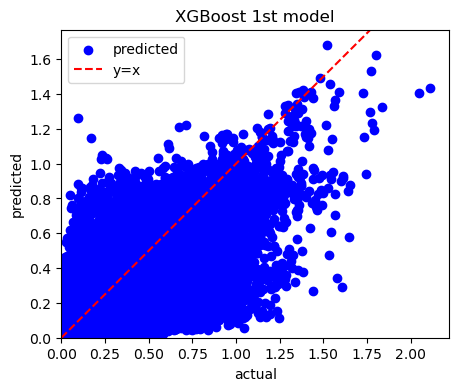

In [21]:
plt.figure(figsize=(5, 4))

plot_results(preds1, y1_test, 'XGBoost 1st model')

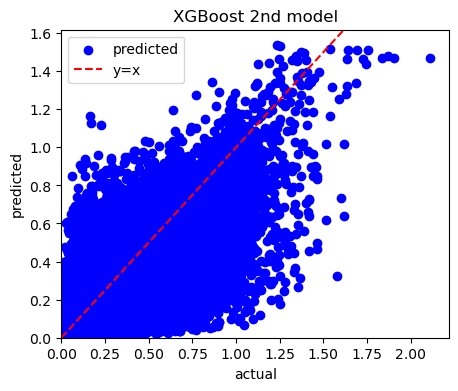

In [22]:
plt.figure(figsize=(5, 4))

plot_results(preds2, y2_test, 'XGBoost 2nd model')

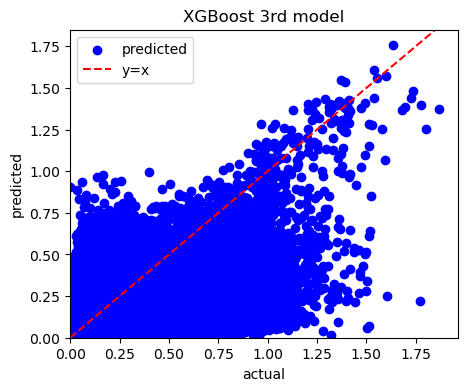

In [23]:
plt.figure(figsize=(5, 4))

plot_results(preds3, y3_test, 'XGBoost 3rd model')

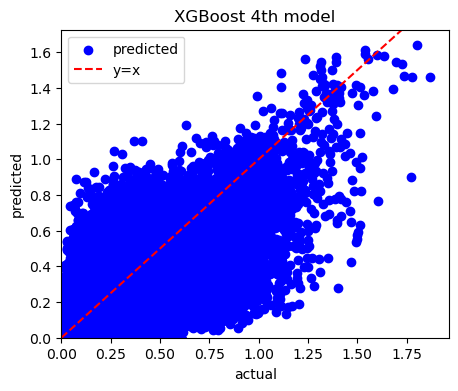

In [27]:
plt.figure(figsize=(5, 4))

plot_results(preds4, y4_test, 'XGBoost 4th model')

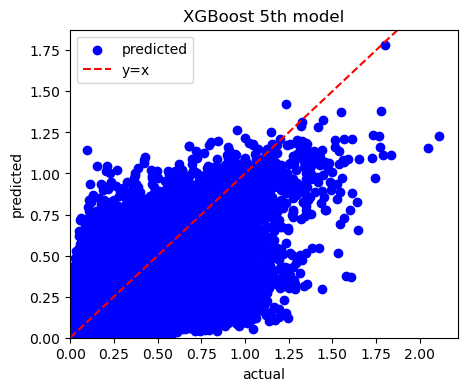

In [25]:
plt.figure(figsize=(5, 4))

plot_results(preds5, y5_test, 'XGBoost 5th model')

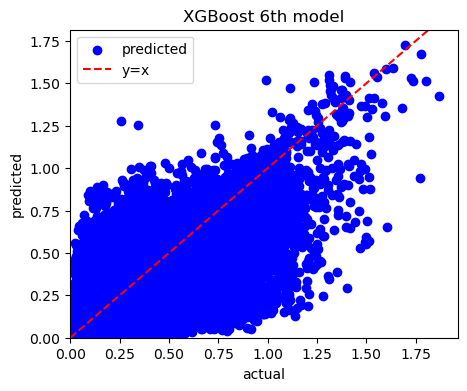

In [26]:
plt.figure(figsize=(5, 4))

plot_results(preds6, y6_test, 'XGBoost 6th model')

In [28]:
print("First Model")
performance_metrics(preds1, y1_test.values.reshape(-1))
print()
print("Second Model")
performance_metrics(preds2, y2_test.values.reshape(-1))
print()
print("Third Model")
performance_metrics(preds3, y3_test.values.reshape(-1))

First Model
RMSE: 0.0714
WAPE: 35.52
R2: 0.6988

Second Model
RMSE: 0.0687
WAPE: 34.92
R2: 0.7165

Third Model
RMSE: 0.0952
WAPE: 53.08
R2: 0.4575


(0.0952, 53.080000000000005, 0.4575)

In [29]:
print("Fourth Model")
performance_metrics(preds4, y4_test.values.reshape(-1))
print()
print("Fifth Model")
performance_metrics(preds5, y5_test.values.reshape(-1))
print()
print("Sixth Model")
performance_metrics(preds6, y6_test.values.reshape(-1))

Fourth Model
RMSE: 0.0683
WAPE: 34.58
R2: 0.7203

Fifth Model
RMSE: 0.0707
WAPE: 35.19
R2: 0.7051

Sixth Model
RMSE: 0.0681
WAPE: 34.45
R2: 0.7225


(0.0681, 34.449999999999996, 0.7225)

## Cross Validation

In [54]:
def cv_validate(classifier, X, y, k):
    scores = cross_validate(classifier, X, y, cv=KFold(n_splits=k, shuffle=True),scoring='r2', return_estimator=True)
    print("R2 score: %0.4f +- %0.4f" % (scores['test_score'].mean(), scores['test_score'].std()))
    return scores

In [55]:
scores1 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X1_train, y1_train, 5)

R2 score: 0.6954 +- 0.0021


In [56]:
scores2 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X2_train, y2_train, 5)

R2 score: 0.7176 +- 0.0019


In [57]:
scores3 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X3_train, y3_train, 5)

R2 score: 0.4542 +- 0.0015


In [58]:
scores4 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X4_train, y4_train, 5)

R2 score: 0.7203 +- 0.0022


In [59]:
scores5 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X5_train, y5_train, 5)

R2 score: 0.7012 +- 0.0027


In [60]:
scores6 = cv_validate(xgb.XGBRegressor(seed=42, tree_method="gpu_hist"), X6_train, y6_train, 5)

R2 score: 0.7217 +- 0.0020


In [37]:
scores1['test_score'], scores2['test_score'], scores3['test_score'], scores4['test_score'], scores5['test_score'], scores6['test_score']

(array([0.69552111, 0.69625478, 0.6923358 , 0.69631913, 0.69522174]),
 array([0.72061444, 0.71785469, 0.71749266, 0.71555522, 0.71921697]),
 array([0.45224575, 0.45119996, 0.45460615, 0.45748803, 0.45470193]),
 array([0.71618351, 0.72181381, 0.71864904, 0.72115867, 0.72422741]),
 array([0.70450717, 0.69665811, 0.70090886, 0.70280764, 0.7015802 ]),
 array([0.71889522, 0.7226909 , 0.72176605, 0.72006731, 0.72457416]))

## Feature Importance

In [38]:
model1.feature_importances_

array([0.00573966, 0.0064277 , 0.00731406, 0.00648722, 0.00666061,
       0.01525376, 0.00526486, 0.00635406, 0.01039763, 0.8798328 ,
       0.01570488, 0.01928034, 0.01528244], dtype=float32)

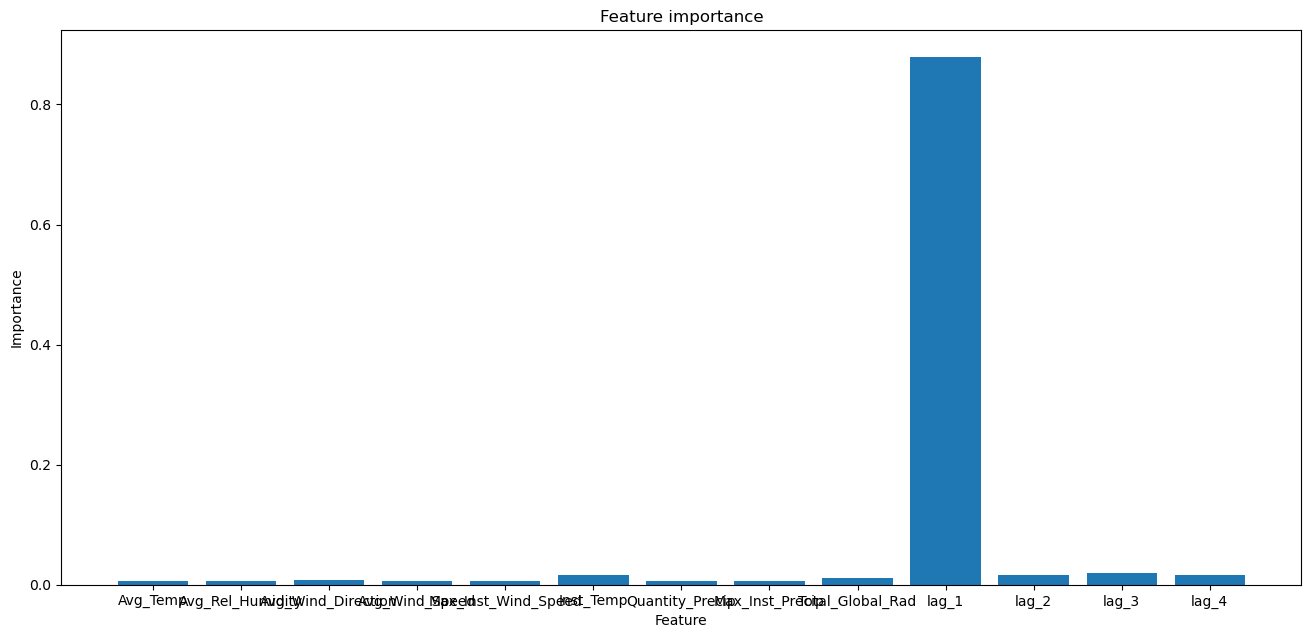

In [39]:
time_importance = model1.feature_importances_

plt.figure(figsize=(16, 7.2))
plt.bar(X1.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

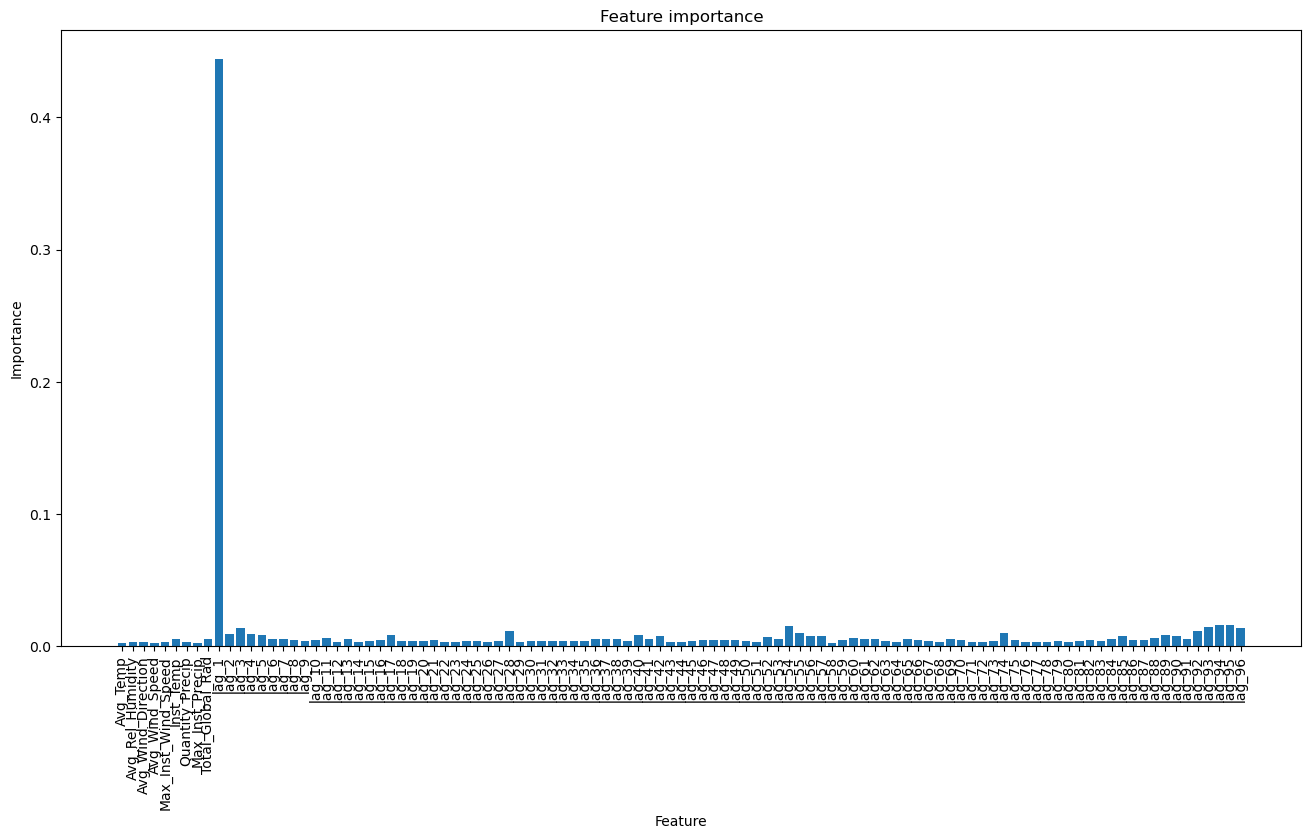

In [40]:
time_importance = model2.feature_importances_

plt.figure(figsize=(16, 8))
plt.bar(X2.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

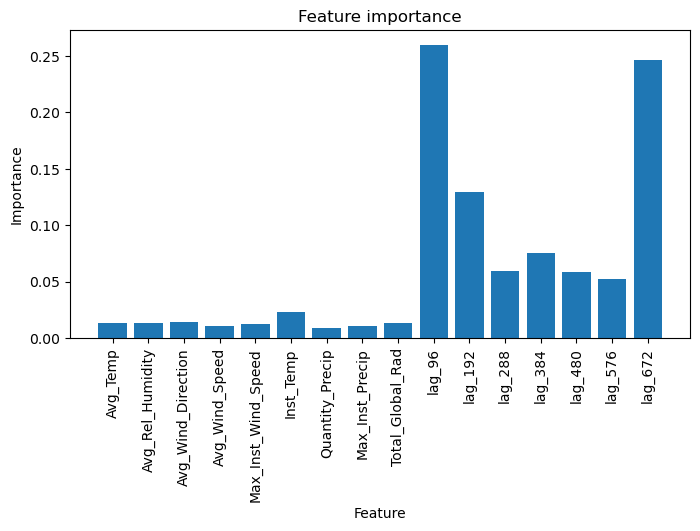

In [62]:
time_importance = model3.feature_importances_

plt.figure(figsize=(8, 4))
plt.bar(X3.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

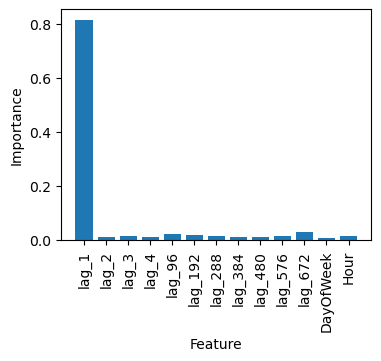

In [69]:
time_importance = model4.feature_importances_

plt.figure(figsize=(4, 3))
plt.bar(X4.columns, time_importance)
#plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

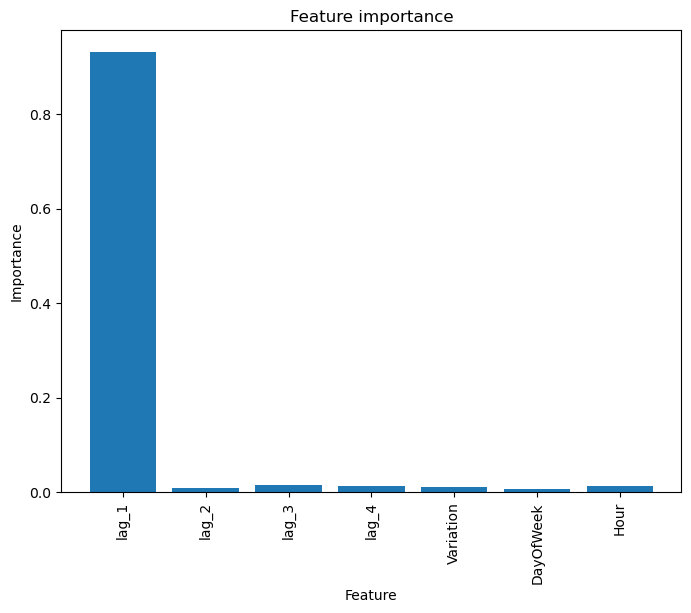

In [43]:
time_importance = model5.feature_importances_

plt.figure(figsize=(8, 6))
plt.bar(X5.columns, time_importance)
plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

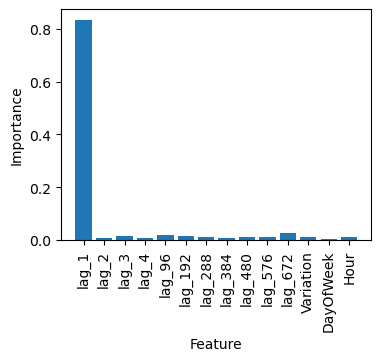

In [70]:
time_importance = model6.feature_importances_

plt.figure(figsize=(4, 3))
plt.bar(X6.columns, time_importance)
#plt.title('Feature importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()